https://fenicsproject.org/pub/tutorial/html/._ftut1009.html

In [1]:
from fenics import *
import numpy as np

T = 5.0            # final time
num_steps = 5000   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# Create mesh
L = 2.2
W = 0.41
n_x = 8
n_y = 8
mesh = RectangleMesh(Point(0,0), Point(L, W), n_x, n_y, "right/left")


In [2]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
# cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

In [3]:
# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
# bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
# bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcu = [bcu_inflow, bcu_walls]
bcp = [bcp_outflow]

In [4]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

In [5]:
# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

In [6]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))


In [7]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

In [8]:
# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# Create XDMF files for visualization output
xdmffile_u = XDMFFile('navier_stokes/velocity.xdmf')
xdmffile_p = XDMFFile('navier_stokes/pressure.xdmf')

# Create VTK files for visualization output
vtkfile_u = File('navier_stokes/velocity.pvd')
vtkfile_p = File('navier_stokes/pressure.pvd')


In [9]:
# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('navier_stokes/velocity_series')
timeseries_p = TimeSeries('navier_stokes/pressure_series')

# Save mesh to file (for use in reaction_system.py)
File('navier_stokes/mesh.xml.gz') << mesh


t = 0.001
n = 0 of 5000
t = 0.002
n = 1 of 5000
t = 0.003
n = 2 of 5000
t = 0.004
n = 3 of 5000
t = 0.005
n = 4 of 5000
t = 0.006
n = 5 of 5000
t = 0.007
n = 6 of 5000
t = 0.008
n = 7 of 5000
t = 0.009000000000000001
n = 8 of 5000
t = 0.010000000000000002
n = 9 of 5000
t = 0.011000000000000003
n = 10 of 5000
t = 0.012000000000000004
n = 11 of 5000
t = 0.013000000000000005
n = 12 of 5000
t = 0.014000000000000005
n = 13 of 5000
t = 0.015000000000000006
n = 14 of 5000
t = 0.016000000000000007
n = 15 of 5000
t = 0.017000000000000008
n = 16 of 5000
t = 0.01800000000000001
n = 17 of 5000
t = 0.01900000000000001
n = 18 of 5000
t = 0.02000000000000001
n = 19 of 5000
t = 0.02100000000000001
n = 20 of 5000
t = 0.022000000000000013
n = 21 of 5000
t = 0.023000000000000013
n = 22 of 5000
t = 0.024000000000000014
n = 23 of 5000
t = 0.025000000000000015
n = 24 of 5000
t = 0.026000000000000016
n = 25 of 5000
t = 0.027000000000000017
n = 26 of 5000
t = 0.028000000000000018
n = 27 of 5000
t = 0.02900000

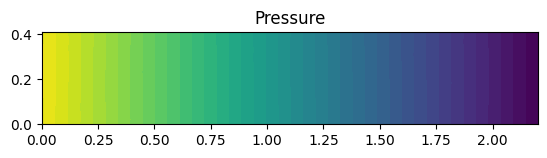

In [10]:
# Create progress bar
# progress = Progress('Time-stepping')
# set_log_level(PROGRESS)

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    print(f't = {t}')
    print(f'n = {n} of {num_steps}')

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
    plot(u_, title='Velocity')
    plot(p_, title='Pressure')

    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t)

    # Save solution to file (VTK)
    # u_, p_ = u.split()
    vtkfile_u << (u_, t)
    vtkfile_p << (p_, t)

    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    timeseries_p.store(p_.vector(), t)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    # Update progress bar
    # progress.update(t / T)
    # print('u max:', u_.vector().array().max())